In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image

import torch
from torchvision import datasets
import torchvision.transforms as transforms
from facenet_pytorch import MTCNN, InceptionResnetV1, extract_face
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder

/Users/crosbynash/Documents/GitHub/ds497-project/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Loading the images to create facial embeddings

In [2]:
# If device is "cuda" then GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print (f"Device: {device}")

Device: cpu


Loading the pre-trained model and using same parameters it was generated with

In [22]:
def whitens(img):
        mean = img.mean()
        std = img.std()
        std_adj = std.clamp(min=1.0 / (float(img.numel()) ** 0.5))
        y = (img - mean) / std_adj
        return y
    
def extract_features(mtcnn, facenet, img):
        img = img.to(device)
        img = transforms.ToPILImage()(img.squeeze_(0))
        bbs, _ = mtcnn.detect(img)
        if bbs is None:
            # if no face is detected
            return None, None

        faces = torch.stack([extract_face(img, bb) for bb in bbs])
        embeddings = facenet(whitens(faces)).detach().numpy()

        return bbs, embeddings
    
def dataset_to_embeddings(dataset, mtcnn, facenet):
    transform = transforms.Compose([
        transforms.Resize(1024),
        transforms.ToTensor()
    ])

    embeddings = []
    labels = []
    for img_path, label in dataset.samples:
        print(img_path)
        
        _, embedding = extract_features(mtcnn, facenet, transform(Image.open(img_path).convert('RGB')).unsqueeze_(0))
        if embedding is None:
            print("Could not find face on {}".format(img_path))
            continue
        if embedding.shape[0] > 1:
            print("Multiple faces detected for {}, taking one with highest probability".format(img_path))
            embedding = embedding[0, :]
        embeddings.append(embedding.flatten())
        labels.append(label)

    return np.stack(embeddings), labels

In [23]:
mtcnn = MTCNN(keep_all=True, thresholds=[0.6, 0.7, 0.9], device=device)
facenet = InceptionResnetV1(pretrained='vggface2').eval()
facenet = facenet.to(device)

In [ ]:
dataset = datasets.ImageFolder(root='./DATASET/')
class_to_idx = dataset.class_to_idx
embeddings, labels = dataset_to_embeddings(dataset, mtcnn, facenet)

./DATASET/fake/person(100).jpg
./DATASET/fake/person(51).jpg
./DATASET/fake/person(52).jpg
./DATASET/fake/person(53).jpg
./DATASET/fake/person(54).jpg
./DATASET/fake/person(55).jpg
./DATASET/fake/person(56).jpg
./DATASET/fake/person(57).jpg
./DATASET/fake/person(58).jpg
./DATASET/fake/person(59).jpg
./DATASET/fake/person(60).jpg
./DATASET/fake/person(61).jpg
./DATASET/fake/person(62).jpg
./DATASET/fake/person(63).jpg
./DATASET/fake/person(64).jpg
./DATASET/fake/person(65).jpg
./DATASET/fake/person(66).jpg
./DATASET/fake/person(67).jpg
./DATASET/fake/person(68).jpg
./DATASET/fake/person(69).jpg
./DATASET/fake/person(70).jpg
./DATASET/fake/person(71).jpg
./DATASET/fake/person(72).jpg
./DATASET/fake/person(73).jpg
./DATASET/fake/person(74).jpg
./DATASET/fake/person(75).jpg
./DATASET/fake/person(76).jpg
./DATASET/fake/person(77).jpg
./DATASET/fake/person(78).jpg
./DATASET/fake/person(79).jpg
./DATASET/fake/person(80).jpg
./DATASET/fake/person(81).jpg
./DATASET/fake/person(82).jpg
./DATASET

In [ ]:
print("Type of embeddings:", type(embeddings))
print("Amount of embeddings per image:", len(embeddings[0]))
print("Number of embeddings:", len(embeddings))
print("Number of images:", len(dataset.imgs))
print('Class to idx:', class_to_idx)

Type of embeddings: <class 'numpy.ndarray'>
Amount of embeddings per image: 512
Number of embeddings: 150
Number of images: 150
Class to idx: {'fake': 0, 'real': 1}


In [ ]:
idx_to_class = {v: k for k, v in class_to_idx.items()}
embeddings_list = [np.array(embed) for embed in embeddings]

embed_dataset = pd.DataFrame({
    "embeddings": embeddings_list,
    "label": [idx_to_class[img[1]] for img in dataset.imgs],
    "image": [os.path.basename(img[0]) for img in dataset.imgs]
})

In [ ]:
embed_dataset.head()

,embeddings,label,image
0,"[0.020330984, -0.008105857, -0.058461007, -0.0...",fake,person(100).jpg
1,"[0.023804545, 0.08565126, -0.004405245, 0.0616...",fake,person(51).jpg
2,"[-0.030333871, 0.037994027, 0.0051515624, 0.05...",fake,person(52).jpg
3,"[0.051420975, 0.03523097, -0.030282669, 0.0292...",fake,person(53).jpg
4,"[-0.028897898, 0.013310191, 0.024527987, 0.006...",fake,person(54).jpg


In [ ]:
embed_dataset.to_pickle("embed_dataset.pkl")

## USING PCA TO REDUCE DIMENSIONALITY OF DATASET

In [3]:
embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

print(np.unique(labels))

dims_to_try = [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {}

for d in dims_to_try:
    pca = PCA(n_components=d)
    reduced_embeddings = pca.fit_transform(embedding_matrix)
    pca_df = pd.DataFrame(reduced_embeddings)
    pca_df["label"] = labels
    pca_df["image"] = image
    pca_dfs[d] = pca_df

pca_dfs[10].head()

['fake' 'real']


,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.291159,0.317489,0.075869,0.000015,-0.147453,0.288102,0.250809,0.177041,-0.162185,-0.229263,fake,person(100).jpg
1,-0.371534,-0.017174,-0.101160,-0.060711,0.140104,-0.062409,-0.010062,0.141181,0.372204,0.078489,fake,person(51).jpg
2,-0.272095,-0.236614,0.252490,-0.165776,-0.043755,0.180840,0.164754,0.060961,0.234188,0.154950,fake,person(52).jpg
3,-0.368602,0.052707,-0.132434,-0.008116,-0.011964,0.273283,0.180933,0.024832,0.041396,-0.120219,fake,person(53).jpg
4,0.321623,-0.101818,0.212691,0.385613,0.194231,0.304588,-0.141177,0.050656,-0.097981,0.000532,fake,person(54).jpg


In [ ]:
for x in pca_dfs.keys():
    pca_dfs[x].to_pickle("df_pca_"+str(x))

In [ ]:
embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

le = LabelEncoder()
y = le.fit_transform(labels)

lda = LDA(n_components=1)
reduced_embeddings = lda.fit_transform(embedding_matrix, y)
lda_df = pd.DataFrame(reduced_embeddings)
lda_df["label"] = labels
lda_df["image"] = image

lda_df.to_pickle("df_lda_1")

In [30]:
pd.read_pickle('df_pca_10').head()

,0,1,2,3,4,5,6,7,8,9,label,image
0,-0.291162,0.317483,0.075881,0.000014,-0.147505,0.287969,0.250802,0.177212,-0.162185,-0.229138,fake,person(100).jpg
1,-0.371535,-0.017186,-0.101162,-0.060730,0.140107,-0.062281,-0.010161,0.140863,0.371377,0.078287,fake,person(51).jpg
2,-0.272087,-0.236584,0.252457,-0.165783,-0.043689,0.181355,0.164718,0.060432,0.234758,0.155089,fake,person(52).jpg
3,-0.368602,0.052721,-0.132417,-0.008106,-0.011963,0.273271,0.181016,0.024943,0.042093,-0.119699,fake,person(53).jpg
4,0.321620,-0.101822,0.212727,0.385606,0.194206,0.304865,-0.141341,0.050206,-0.098759,0.001201,fake,person(54).jpg


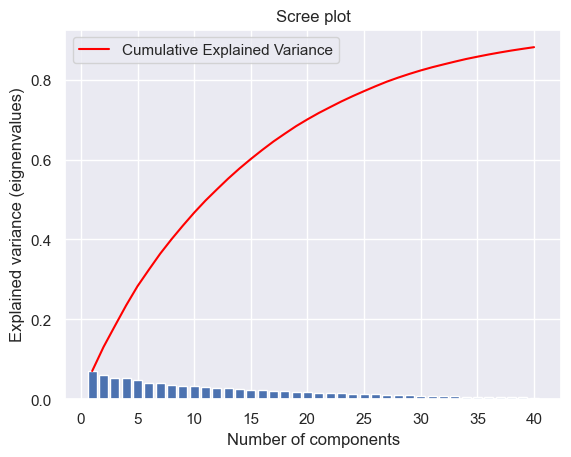

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set()

embed_dataset = pd.read_pickle('embed_dataset.pkl')
embedding_matrix = np.vstack(embed_dataset["embeddings"].values)
labels = embed_dataset["label"].values
image = embed_dataset["image"].values

lda = PCA(n_components=40)
reduced_embeddings = lda.fit_transform(embedding_matrix)
lda_df = pd.DataFrame(reduced_embeddings)
lda_df["label"] = labels
lda_df["image"] = image
 
# Scree Plot
import numpy as np
# Bar plot of explained_variance
plt.bar(
    range(1,len(lda.explained_variance_)+1),
    lda.explained_variance_
    )
 
plt.plot(
    range(1,len(lda.explained_variance_ )+1),
    np.cumsum(lda.explained_variance_),
    c='red',
    label='Cumulative Explained Variance')
 
plt.legend(loc='upper left')
plt.xlabel('Number of components')
plt.ylabel('Explained variance (eignenvalues)')
plt.title('Scree plot')
 
plt.show()